# Time warpping PCA
step1: time-warping the single letter data to initialize the data-labeling HMM. results saved in Step1_TimeWarping folder. 
也即把PCA后的实验数据进行时间对齐，因为整体书写时间不相等（尽管书写出来的字符是大体类似的）

In [1]:

import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"  # GPU显存不够，故禁用
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)  # 禁用warnings 输出
import numpy as np
import scipy.io
import scipy.ndimage.filters
import matplotlib.pyplot as plt
from twpca import TWPCA
from twpca.regularizers import curvature
import sys
sys.path.append("../handwritingBCI/") # 这样就可以引用其中的py文件
from characterDefinitions import getHandwritingCharacterDefinitions
# 数据根目录和11个session的文件夹名（位于dataset目录下）
rootDir =  '../handwritingBCI/handwritingBCIData/'
dataDirs = ['t5.2019.05.08','t5.2019.11.25','t5.2019.12.09','t5.2019.12.11','t5.2019.12.18',
            't5.2019.12.20','t5.2020.01.06','t5.2020.01.08','t5.2020.01.13','t5.2020.01.15']
# 创建结果存放文件夹, 存放在cache目录下(以root-dir为根目录)
res_dir = rootDir+"cache/RNNTrainingSteps/Step1_TimeWarping/"
if not os.path.isdir(res_dir):
    os.makedirs(res_dir)  # 注意不使用mkdir, 因为是多层目录

## 字符集
接下来是字符集的读取，包含31个字符，也即26个小写字母和(>,'~?)其中>被用于空格. `charDef`是一个字典，包含的键值为`dict_keys(['charList', 'charListAbbr', 'charLen', 'penStart', 'strToCharIdx', 'kaldiOrder', 'idxToKaldi'])`，它们每一个都是长度为31(32)的列表或数组或字典.
1. charList是字符列表，其中>等非字母符号使用单词表示，例如greaterThan  
2. charListAbbr是字符缩写列表，其中非字母符号直接表示，例如>  
3. charLen是**字符长度**array数组，均为整数，范围区间[68, 132]，理解为笔尖书写该字母时走过的轨迹长度，也可以理解为书写该字母的整体用时，这是手工定义的  
4. penStart是指书写这一字母时笔尖起始位置列表，从[0, 0.25, 0.5, 1.0]中取，值越小起始位置月接近底部线  
5. strToCharIdx是一个字典，他把a,>?b等等字符映射为0到30的index  
6. kaldiOrder是一个字符列表，长度32，称为语料，用于语言模型（例如kaldi），'<ctc>'表示未定义，也即不在这31个字符中的所有字符将映射为'<ctc>'
7. idxToKaldi是一个array数组，长度32，由于语料列表字符顺序不同于charList，故这里也专门定义一个index列表

In [2]:
charDef = getHandwritingCharacterDefinitions()
charDef['charList'][charDef['idxToKaldi'][2]], charDef['kaldiOrder'][2]

('apostrophe', "'")

## 单字符数据集的读取与处理
loadmat读取的mat文件以dict类型进行存储，键值包含:  
1. `'__header__', '__version__', '__globals__'`: 文件头信息
2. `neuralActivityCube_xxx'`系列，包括doNothing以及charList列出的31个字符  
3. `'neuralActivityTimeSeries'`:
4. `'clockTimeSeries'`:
5. `'blockNumsTimeSeries'`: 336932x1的数组(336932为所有实验的时间步数)，第i个元素表示该时间步对应的块号，使用10ms的时间步。这可以用来determine the block during which any time step of data was recorded
6. `'blockList'`: 块号列表[ 5  7  9 11 13 15 17 19 23]
7. `'blockStartDates'`:
8. `'goPeriodOnsetTimeBin'`: 864x1的数组(32x27)，其中第i个元素表示第i次实验在给出go指令的时间步号
9. `'delayPeriodOnsetTimeBin'`:
10. `'characterCues'`: 864x1的数组(32x27)，其中第i个元素表示第i次实验的字符
11. `'meansPerBlock'`: 
12. `'stdAcrossAllData'`:
13. `'arrayGeometryMap'`:
### dat['neuralActivityCube_a']
1. `dat['neuralActivityCube_a'].shape = (27, 201, 192)`, 对于单个字符进行了27次实验(dim=0), 一共201个bin，192个电极  
2. `dat['neuralActivityCube_a'][0][:, 0]`表示在针对字符a进行的27次实验中的第一次实验的第一个电极测得的神经活动时间序列，包含201个时间bin，一个为10ms，每一个bin内的值表示该bin内神经信号曲线穿过阈值的次数。因而这已经是将原始神经信号波形（振荡）曲线处理后得到的输入，并且可以理解为相对值（而不是绝对的神经信号值）。

### 时间步、实验、块
目前的理解是，时间步是类似于时钟周期，是实验和块时间序列度量的基本单位，实验是指针对某一字符进行的实验，他可以持续多个时间步，块是一组实验，针对了多个不同的字母。

In [3]:
def avg_stdize(charDef, dat):
    for char in charDef['charList']:
        neuralCube = dat['neuralActivityCube_'+char].astype(np.float64)
        # 获取所有该字符的实验编号, 32x27, len(trlIdx)=27
        trlIdx = []
        for t in range(dat['characterCues'].shape[0]):
            if dat['characterCues'][t,0]==char:
                trlIdx.append(t)
        # dat['goPOTB'][trlIdx]表示该字母27次实验中go指令发出时的时间步号
        # 接着得到该字母27次实验go指令对应时间步所在的块号
        blockIdx = dat['blockNumsTimeSeries'][dat['goPeriodOnsetTimeBin'][trlIdx]]
        blockIdx = np.squeeze(blockIdx) # squeeze表示去掉多余的维度
        # 将神经信号值按块进行均值归一化
        for b in range(dat['blockList'].shape[0]):
            trialsFromThisBlock = np.squeeze(blockIdx==dat['blockList'][b])
            neuralCube[trialsFromThisBlock,:,:] -= dat['meansPerBlock'][np.newaxis,b,:]
        neuralCube = neuralCube / dat['stdAcrossAllData'][np.newaxis,:,:]
        dat['neuralActivityCube_'+char] = neuralCube
    return dat

def time_warp(dat, char):
    n_components = 5  # 用于去噪的主成分数量，同时对数据做近似降维处理
    warp_regularizer = curvature(scale=0.001, power=1)  # L1正则化
    time_regularizer = curvature(scale=1.0, power=2, axis=0)  # L2正则化
    # 对经过均值归一化的数据进行一阶高斯平滑，这一步非常重要
    smoothed_spikes = scipy.ndimage.filters.gaussian_filter1d(dat['neuralActivityCube_'+char], 3.0, axis=1)
    model = TWPCA(smoothed_spikes, n_components, 
                  warp_regularizer=warp_regularizer, 
                  time_regularizer=time_regularizer).fit(progressbar=False)
    estimated_aligned_data = model.transform(dat['neuralActivityCube_'+char])
    return estimated_aligned_data, model.params['warp'].T.copy()

def run():
    for dataDir in dataDirs:
        print('Warping dataset: ' + dataDir)
        dat = scipy.io.loadmat(rootDir+'Datasets/'+dataDir+'/singleLetters.mat')
        dat = avg_stdize(charDef, dat)
        alignedDat = {}
        # 按字符进行时间对齐
        for char in charDef['charList']:
            print('\tWarping character: ' + char)
            tf.reset_default_graph()   # 清除默认图节点，也即前一次运行保留的节点不会累积
            alignedDat[char], alignedDat[char+'_T'] = time_warp(dat, char)
#             return alignedDat[char], alignedDat[char+'_T']
        #save time-warped characters as a .mat file
        fileName = res_dir + dataDir + '_warpedCubes.mat'
        print('Saving ' + fileName)
        scipy.io.savemat(fileName, alignedDat)
# run()

In [5]:
# 特例分析
t520190508_dat = scipy.io.loadmat(rootDir+'Datasets/t5.2019.05.08/singleLetters.mat')
t520190508_avgstd_dat = avg_stdize(charDef, t520190508_dat)
char = 'a'
n_components = 5  # 用于去噪的主成分数量，同时对数据做近似降维处理
warp_regularizer = curvature(scale=0.001, power=1)  # L1正则化
time_regularizer = curvature(scale=1.0, power=2, axis=0)  # L2正则化
# 对经过均值归一化的数据进行一阶高斯平滑，这一步非常重要
smoothed_spikes = scipy.ndimage.filters.gaussian_filter1d(
    t520190508_avgstd_dat['neuralActivityCube_'+char], 3.0, axis=1)
smoothed_spikes.shape

(27, 201, 192)

In [98]:
a_aligned.shape, a_param.shape

((27, 201, 192), (201, 27))

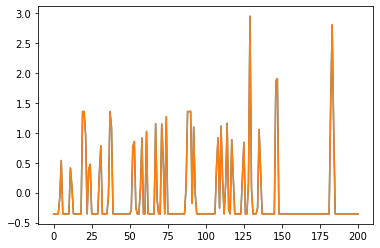

In [100]:
plt.plot(list(range(201)), a_aligned[0, :, 0])
plt.show()

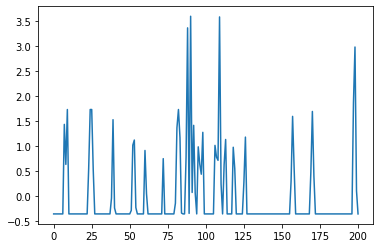

In [101]:
plt.plot(list(range(201)), a_aligned[0, :, 1])
plt.show()